# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output
from keras import layers

In [2]:
import tensorflow

# Dataset

In [7]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

AttributeError: module 'tensorflow_datasets' has no attribute 'load'

# Pre-Processing

In [14]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [6]:
def myfunction(x,y,z):
  a = x+ y+ z * 43
  b = x^2 + 4-y*z
  return a , b

m ,n = myfunction(4, 5, 6)

In [7]:
print('m = ', m)
print('n = ', n)

m =  267
n =  -20


In [15]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
   # Random flipping of the image and mask
      input_image = tf.image.flip_left_right(input_image)
      
      input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [16]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [17]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [18]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

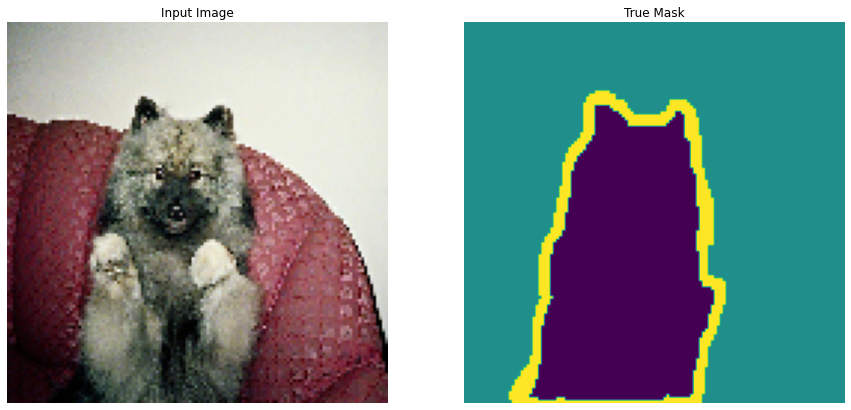

In [22]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])


In [25]:
def double_conv_block(x, n_filters):

 # Conv2D then ReLU activation
 x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
 # Conv2D then ReLU activation
 x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

 return x

In [26]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [27]:
def upsample_block(x, conv_features, n_filters):
 # upsample
 x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
 # concatenate
 x = layers.concatenate([x, conv_features])
 # dropout
 x = layers.Dropout(0.3)(x)
 # Conv2D twice with ReLU activation
 x = double_conv_block(x, n_filters)

 return x

In [28]:
# inputs
inputs = layers.Input(shape=(128,128,3))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64)
# 2 - downsample
f2, p2 = downsample_block(p1, 128)
# 3 - downsample
f3, p3 = downsample_block(p2, 256)
# 4 - downsample
f4, p4 = downsample_block(p3, 512)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

#return unet_model

In [30]:
unet_model.summery()

AttributeError: ignored

In [31]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
#We train the unet_model by calling model.fit() and training it for 20 epochs.

NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE



VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 95s 1s/step - loss: 0.9833 - accuracy: 0.5804 - val_loss: 0.8968 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 71s 1s/step - loss: 0.7216 - accuracy: 0.6987 - val_loss: 0.6686 - val_accuracy: 0.7209
Epoch 3/20
57/57 [==============================] - 64s 1s/step - loss: 0.6394 - accuracy: 0.7393 - val_loss: 0.6187 - val_accuracy: 0.7545
Epoch 4/20
57/57 [==============================] - 64s 1s/step - loss: 0.5799 - accuracy: 0.7681 - val_loss: 0.5558 - val_accuracy: 0.7794
Epoch 5/20
57/57 [==============================] - 64s 1s/step - loss: 0.5255 - accuracy: 0.7941 - val_loss: 0.4683 - val_accuracy: 0.8159
Epoch 6/20
57/57 [==============================] - 64s 1s/step - loss: 0.4885 - accuracy: 0.8101 - val_loss: 0.4510 - val_accuracy: 0.8259
Epoch 7/20
57/57 [==============================] - 64s 1s/step - loss: 0.4634 - accuracy: 0.8211 - val_loss: 0.4182 - val_accuracy: 0.8388
Epoch 8/20
57/57 [==

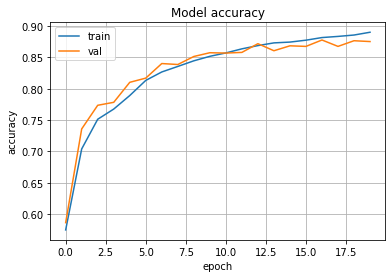

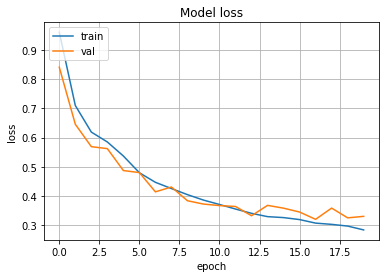

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 1s/step


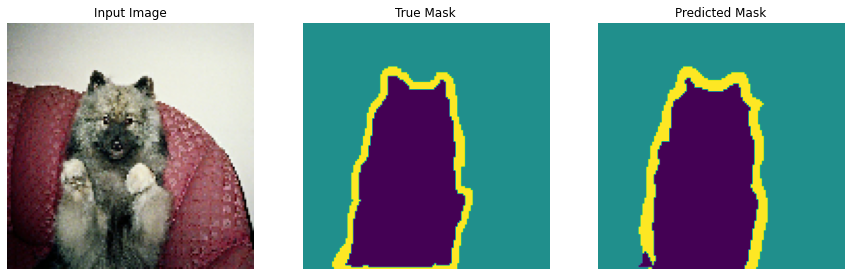

In [32]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()